In [218]:
%pylab inline

import os
from glob import glob
import xarray as xr
import pandas as pd
import seaflux as sf
import ocean_data_tools as odt
import pooch
import zipfile
from cartopy import crs, feature

import seaborn
seaborn.set_palette('tab20')

Populating the interactive namespace from numpy and matplotlib


In [245]:
# the data are available in z-arr and netCDF format - let me know if you'd like access to the final product

xds = xr.open_zarr('../data-in/reccap2_dataProducts7_pco2_flxParams.zarr').sel(time=slice('1985', '2018'))
# xds = xr.open_dataset('../data-in/reccap2_dataProducts7_pco2+flxParams.nc').sel(time=slice('1985', '2018'))

In [246]:
data = xr.open_zarr('../../OceanSODA/DataPrep/data/colocated_data_socat_glodap_1985-2018_2.zarr/')

# SOCAT data density

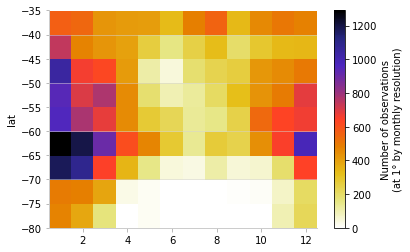

In [261]:
so_socat = data.pCO2_socat.where(xds.regions_SO.notnull())
n_obs = so_socat.groupby('time.month').count('time')
n_obs.sum(['lon']).sel(lat=slice(-90, -30)).coarsen(lat=5).sum().T.plot(cmap=cm.CMRmap_r)
odt.plotting.pimp_plot()
gca().set_ylim(-80, -35)
cax = gcf().get_children()[-1]
cax.set_ylabel('Number of observations\n(at 1° by monthly resolution)')
show()

# $\Delta p$CO$_2$ (global)

In [220]:
df = (
    (xds.pco2sea - xds.pco2atm)
    .where(xds.pco2sea.sel(meth=['mpiSOMFFN']).notnull().all('meth'))
#     .weighted(sf.utils.area_grid())
    .median(['lat', 'lon'])
    .load()
    .rolling(time=12).mean()
    .to_series()
    .unstack(0)
)

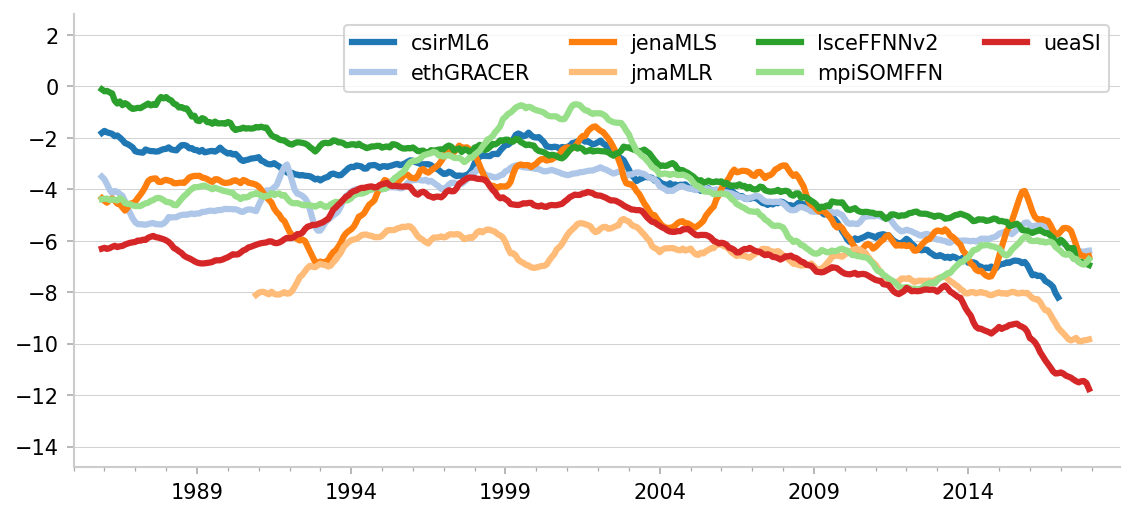

In [221]:
fig, ax = subplots(figsize=[9, 4], dpi=150)

df.plot.line(lw=3, ax=ax)
odt.plotting.pimp_plot(ax=ax)
ax.legend(ncol=4)

# Fluxes

Calculate the fluxes using the bulk formulation of fluxes. For now I'm using $k_w$ from Wanninkhof et al. (2009) without global scaling. This can easily be adjusted later on. 

Products used to calculate fluxes:
- SST = OSTIA (foundation temperature)
- Salinity = SODA 3.4.2
- Pressure = ERA5
- Wind speed = ERA5 computed from daily averages of $U_{10}$ and $V_{10}$
- Atmospheric pCO2 = NOAA Marine Boundary Layer $x\text{CO}_2 \times (P_{atm} - p\text{H}{_2}\text{O})$

In [222]:
%%time

flux = sf.flux_bulk(
    xds.sst,
    xds.salt.clip(5, 100),
    xds.pco2sea,
    xds.pco2atm,
    xds.press_atm/100,
    xds.wind_speed,
    kw_func=sf.gas_transfer_CO2.k_Wa09,
)

/home/gregorl/Git/SeaFlux/seaflux/unit_checks.py:12: RuntimeWarning: invalid value encountered in greater
  outside = func(arr, lim)
/home/gregorl/Git/SeaFlux/seaflux/unit_checks.py:12: RuntimeWarning: invalid value encountered in greater
  outside = func(arr, lim)
/home/gregorl/Git/SeaFlux/seaflux/unit_checks.py:12: RuntimeWarning: invalid value encountered in greater
  outside = func(arr, lim)


CPU times: user 15.3 s, sys: 5.81 s, total: 21.1 s
Wall time: 21.8 s


In [226]:
mask = flux.notnull().all('meth')

## Southern Ocean flux calculation

The flux output is in gC / m2 / day . Multiply this by 365 to get to gC / m2 / yr

In [227]:
flux_so = flux.where(xds.regions_SO.notnull() & mask)

flux_integrated = (flux_so * xds.area * (1 - xds.ice_frac)).sum(['lat', 'lon']).to_series().unstack(0)
flux_integrated = (flux_integrated * 365)
flux_integrated = flux_integrated.where(flux_integrated != 0)

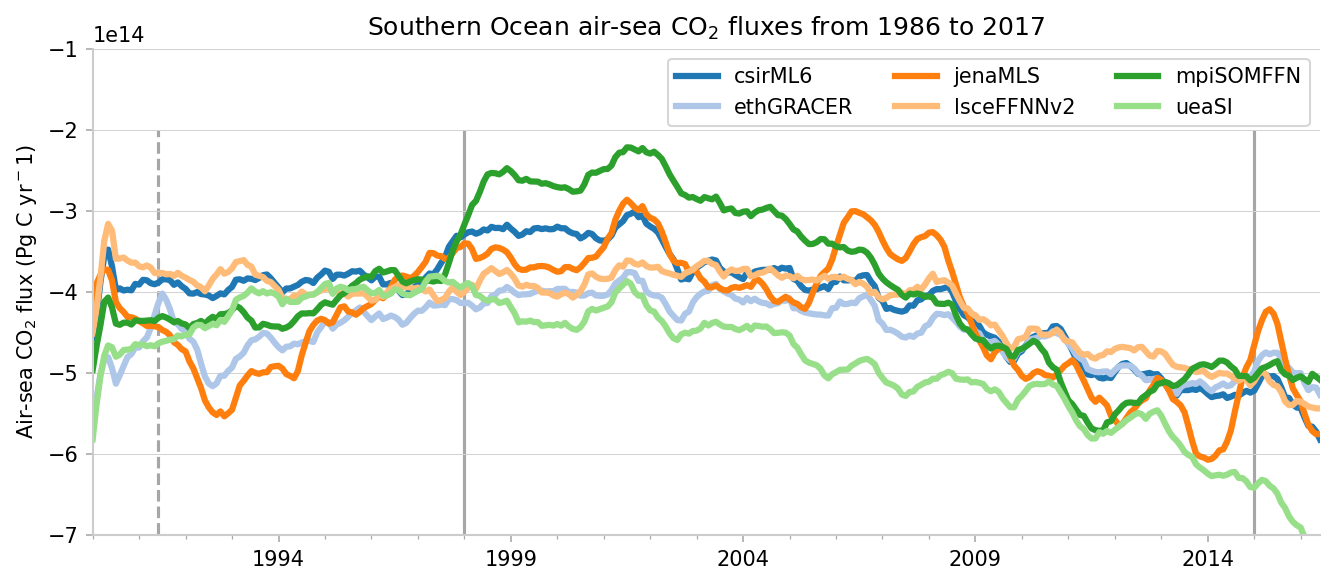

In [240]:
fig, ax = subplots(figsize=[9, 4], dpi=150)

df = (flux_integrated
      .drop(columns=['jmaMLR'])
      .rolling(window=12, min_periods=1, center=True).mean()
      .loc['1990':'2016-06']
     )

cols = df.columns.values.tolist()

df.plot.line(ax=ax, lw=3)
ax.vlines(['1991-06-15'], -8e14, -2e14, color='grey', ls='--', zorder=-1, alpha=0.7)
ax.vlines(['1998', '2015'], -8e14, -2e14, color='grey', ls='-', zorder=-1, alpha=0.7)

odt.plotting.pimp_plot(ax=ax)
ax.legend(ncol=3)
ax.set_title('Southern Ocean air-sea CO$_2$ fluxes from 1986 to 2017')
ax.set_ylabel('Air-sea CO$_2$ flux (Pg C yr${^-1}$)')
ax.set_ylim(-7e14, -1e14)

fig.tight_layout()

## Southern Ocean regional fluxes

We've split the SO into basins and biomes according to Fay and McKinley (2014). 
The basins are divided at -70°E, 20°E and 147°E. 

The names of the biomes are:
- STSS = Subtoprical Seasonally Stratified
- SPSS = Subpolar Seasonally Stratified
- ICE = Region covered by at least 50% ice at some point in the year

In [230]:
basin = ['Atl', 'Ind', 'Pac']
biome = ['STSS', 'SPSS', 'ICE']
region_names = (
    pd.DataFrame(
        data=np.array([a for a in np.meshgrid(basin, biome)]).reshape(2, -1).T, 
        columns=['basin', 'biome'])
    .sort_values('basin')
    .reset_index(drop=True)
    .apply(lambda a: '-'.join(a.values), axis=1)
)

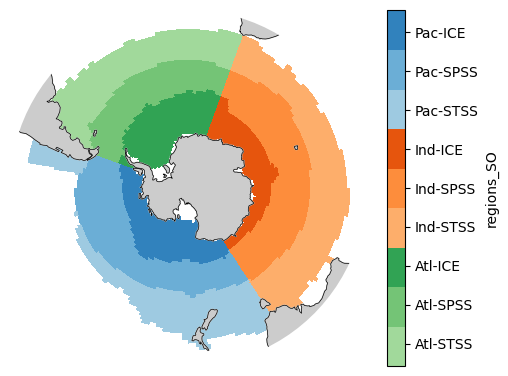

In [231]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(cm.tab20c([0, 1, 2, 4, 5, 6, 8, 9, 10][::-1]))

ax = xds.regions_SO.sel(lat=slice(-90, -35)).plot_map(proj=crs.Stereographic(central_latitude=-90), cmap=cmap)
ax.colorbar.set_ticks(np.linspace(0.5, 7.5, 9))
ax.colorbar.set_ticklabels(region_names.values)
ax.outline_patch.set_linewidth(0)

In [233]:
# First calculate integrated flux for each of the regions 
flux_regions = []
for r in range(9):
    print(r, end='.')
    region = xds.regions_SO == r
    flux_regions += (flux.where(region & mask) * xds.area * (1 - xds.ice_frac) * 365).sum(['lat', 'lon']),

flux_regions = xr.concat(
    flux_regions, dim='regions'
).assign_coords(
    regions=region_names.values
)

0.1.2.3.4.5.6.7.8.

0.1.2.3.4.5.6.7.8.

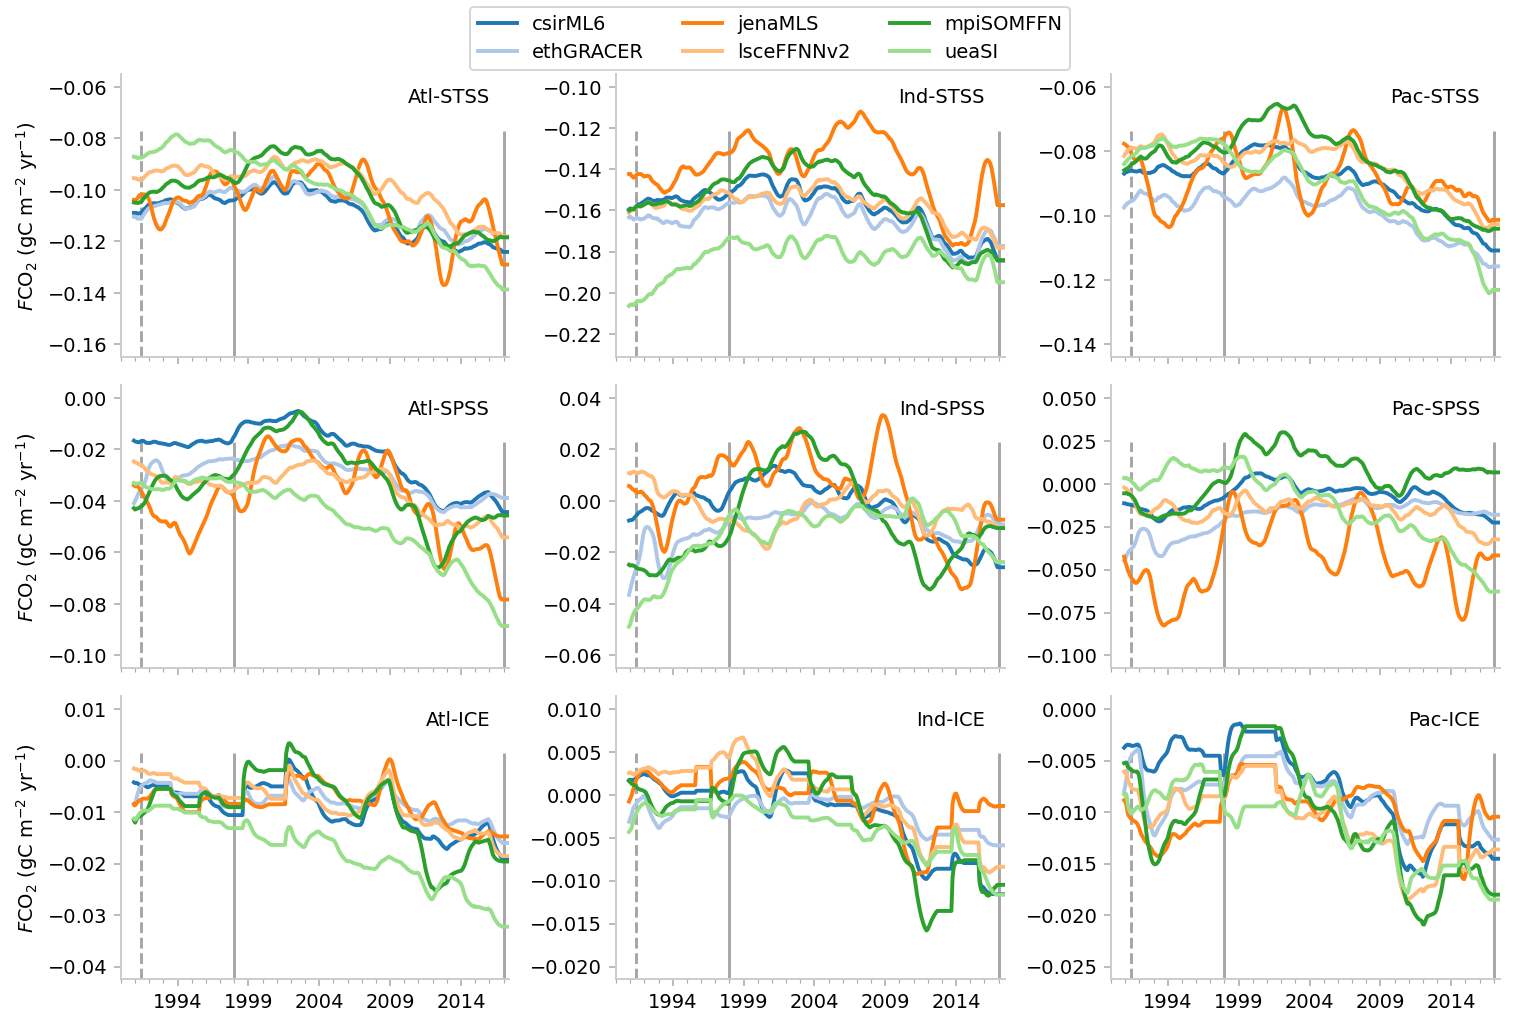

In [243]:
fig, ax = subplots(3, 3, figsize=[11, 7], dpi=140, sharex=True)
# Transposing axes so that numbering runs column-wise
ax = ax.T.flatten()

for r in range(9):
    print(r, end='.')
    df = flux_regions[r].to_series().unstack(0)
    df = (df
          .where(df != 0)
          .rolling(window=12).mean()
          .ewm(span=12).mean()
          * 1e-15
         )[cols]
    lines = df.plot.line(ax=ax[r], lw=2, legend=False)
    
    odt.plotting.pimp_plot(ax[r], lw=0)
    ax[r].text(0.95, 0.95, flux_regions.regions[r].values, transform=ax[r].transAxes, ha='right', va='top')
    ylims = ax[r].get_ylim()
    ax[r].set_ylim(*ylims)
    ax[r].set_xlim('1990', '2017-06')
    
    y0 = ylims[0]
    y1 = ylims[1] - np.diff(ylims) * 0.2
    ax[r].vlines(['1991-06-15'], y0, y1, color='grey', ls='--', zorder=-1, alpha=0.7)
    ax[r].vlines(['1998', '2017'], y0, y1, color='grey', ls='-', zorder=-1, alpha=0.7)

[ax[i].set_ylabel('$F$CO$_2$ (gC m$^{-2}$ yr$^{-1}$)') for i in [0, 1, 2]]
fig.legend(lines.get_lines(), cols, ncol=3, loc=9, bbox_to_anchor=[0.5, 1.05])

fig.tight_layout()

# Time integrated fluxes

In [348]:
import warnings 
warnings.filterwarnings('ignore', category=RuntimeWarning)
so_map = dict(proj=crs.Stereographic(central_latitude=-90))

In [304]:
flux_so_ens = flux.drop(['ueaSI', 'jmaMLR'], 'meth').where(xds.regions_SO.notnull()).sel(lat=slice(-90, -35))
flx_ens = flux_so_ens.mean('meth')
ens_std = flux_so_ens.std('meth')
ens_count = flux_so_ens.count('meth')

In [350]:
count = flux.where(xds.regions_SO.notnull()).sel(lat=slice(-90, -35)).groupby('time.month').count('time')

In [351]:
df_count = count.sum(['lat', 'lon']).to_series().unstack(0)[cols]

In [358]:
a = flux.where(xds.regions_SO.notnull()).sel(lat=slice(-90, -35))[0]

In [371]:
grps = a.groupby('time.season')

In [386]:
b = a.notnull().sum(['lat', 'lon']).to_series()

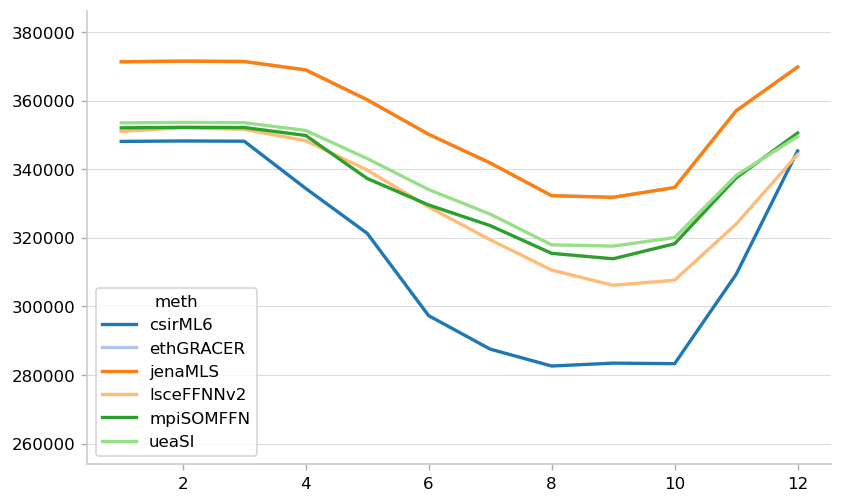

In [403]:
fig, ax = subplots(figsize=[8, 5], dpi=120)
df_count.plot(lw=2, ax=ax)
odt.plotting.pimp_plot(ax)

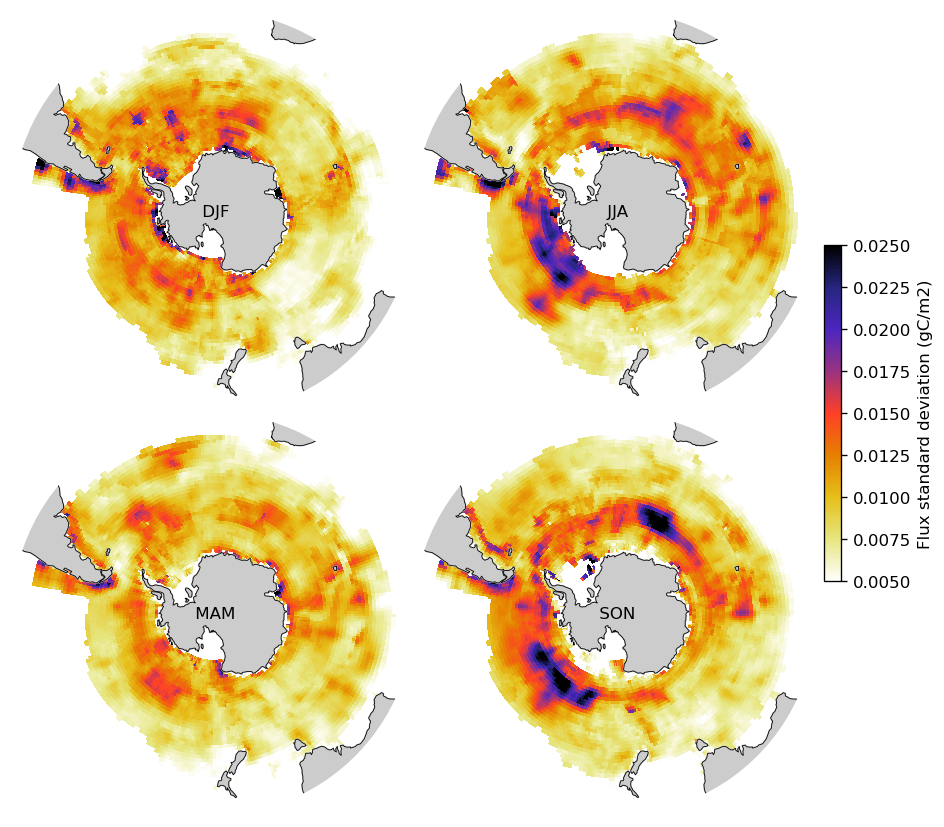

In [434]:
seasons = ens_std.groupby('time.season').mean('time')

fig, ax = subplots(2, 2, figsize=[7, 7], dpi=120, subplot_kw=dict(projection=crs.Stereographic(central_latitude=-90)))
ax = ax.reshape(-1)
for i, xda in enumerate(seasons):
    img = xda.plot_map(ax=ax[i], vmin=0.005, vmax=0.025, add_colorbar=False, cmap=cm.CMRmap_r)
    ax[i].outline_patch.set_linewidth(0)
    ax[i].text(0.5, 0.5, ax[i].get_title().split('=')[1], ha='center', va='center', zorder=2000)
    ax[i].set_title('')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
p1 = ax[1].get_position()
cax = fig.add_axes([p1.x1 + 0.01, 0.3, 0.02, 0.4])
cbar = plt.colorbar(img.get_children()[0], cax=cax)
cbar.set_label('Flux standard deviation (gC/m2)')

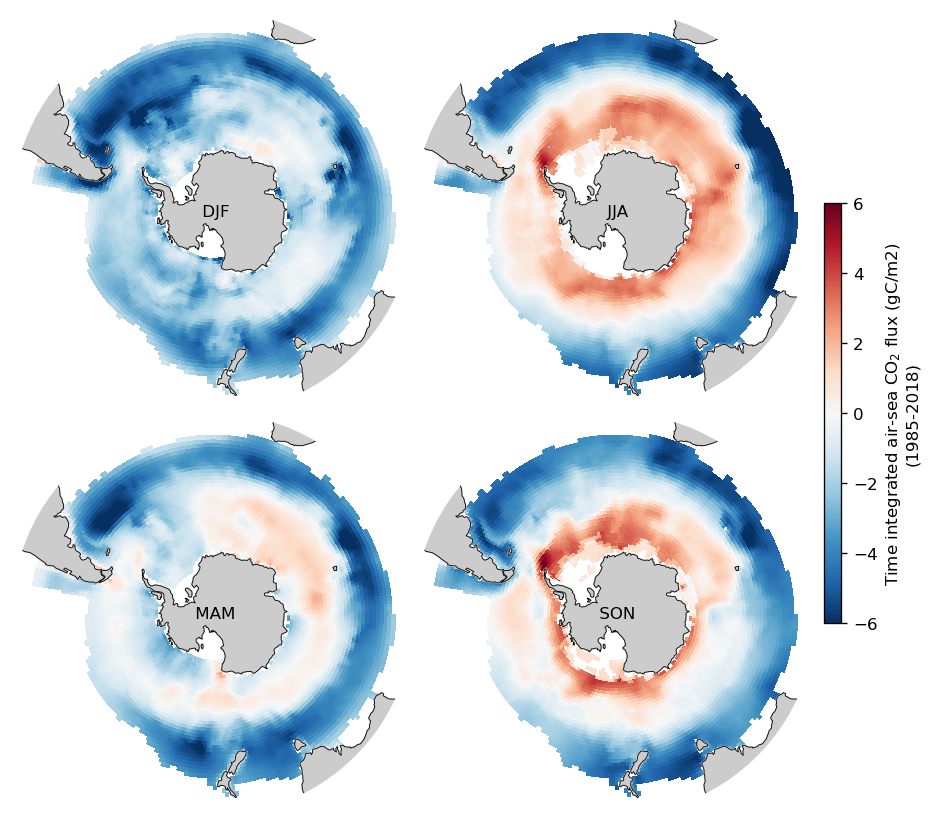

In [436]:
seasons = flx_ens.groupby('time.season').sum('time')

fig, ax = subplots(2, 2, figsize=[7, 7], dpi=120, subplot_kw=dict(projection=crs.Stereographic(central_latitude=-90)))
ax = ax.reshape(-1)
for i, xda in enumerate(seasons):
    xda = xda.where(xda != 0)
    img = xda.plot_map(ax=ax[i], add_colorbar=False, cmap=cm.RdBu_r, vmin=-6, vmax=6)
    ax[i].outline_patch.set_linewidth(0)
    ax[i].text(0.5, 0.5, ax[i].get_title().split('=')[1], ha='center', va='center', zorder=2000)
    ax[i].set_title('')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
p1 = ax[1].get_position()
cax = fig.add_axes([p1.x1 + 0.01, 0.25, 0.02, 0.5])
cbar = plt.colorbar(img.get_children()[0], cax=cax)
cbar.set_label('Time integrated air-sea CO$_2$ flux (gC/m2)\n(1985-2018)')